In [2]:
import numpy as np # linear algebra
# version of panda should be 0.25.1 because of .ix function
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# pip install opencv-python
import cv2

# pip install tqdm
from tqdm import tqdm

from sklearn.model_selection import KFold
import time


In [28]:


x_train = []
x_test = []
y_train = []

df_train = pd.read_csv('./train_v2.csv')
# df_test = pd.read_csv('./dataset/sample_submission_v2.csv')

flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))


In [29]:

labels = ['blow_down',
          'bare_ground',
          'conventional_mine',
          'blooming',
          'cultivation',
          'artisinal_mine',
          'haze',
          'primary',
          'slash_burn',
          'habitation',
          'clear',
          'road',
          'selective_logging',
          'partly_cloudy',
          'agriculture',
          'water',
          'cloudy']

label_map = {'agriculture': 14,
             'artisinal_mine': 5,
             'bare_ground': 1,
             'blooming': 3,
             'blow_down': 0,
             'clear': 10,
             'cloudy': 16,
             'conventional_mine': 2,
             'cultivation': 4,
             'habitation': 9,
             'haze': 6,
             'partly_cloudy': 13,
             'primary': 7,
             'road': 11,
             'selective_logging': 12,
             'slash_burn': 8,
             'water': 15}


In [30]:

for f, tags in tqdm(df_train.values[:9800], miniters=1000):
    img = cv2.imread('./train-jpg/{}.jpg'.format(f))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1
    x_train.append(cv2.resize(img, (128, 128)))
    y_train.append(targets)


y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float32) / 255.
# x_test = np.array(x_test, np.float32) / 255.




100%|██████████| 9800/9800 [00:20<00:00, 480.61it/s]


In [31]:

###############################

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import fbeta_score

X_train, X_valid, Y_train, Y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print('Training data shape:', X_train.shape, Y_train.shape)
print('Validation data shape:', X_valid.shape, Y_valid.shape)

kfold_weights_path = os.path.join('', 'weights.keras')

base_model = ResNet50(weights=None, include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = False


    model = Sequential([
        base_model,

        Flatten(),

        Dense(128, activation='tanh'),
        Dropout(0.2),
        Dense(17, activation='sigmoid')

    ])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


Training data shape: (7840, 128, 128, 3) (7840, 17)
Validation data shape: (1960, 128, 128, 3) (1960, 17)


In [32]:

callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, verbose=0),
    ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=0)
]

model.fit(x=X_train, y=Y_train, validation_data=(X_valid, Y_valid),
          batch_size=128, verbose=1, epochs=30, callbacks=callbacks,
          shuffle=True)

print(model.summary())

if os.path.isfile(kfold_weights_path):
    model.load_weights(kfold_weights_path)

p_valid = model.predict(X_valid, batch_size=128, verbose=2)
print("F beta score: " + str(fbeta_score(Y_valid, np.array(p_valid) > 0.2, beta=2, average='samples')))

Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.6602 - loss: 0.3238 - val_accuracy: 0.7240 - val_loss: 0.2475
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.7161 - loss: 0.2532 - val_accuracy: 0.7240 - val_loss: 0.2367
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.7156 - loss: 0.2413 - val_accuracy: 0.7240 - val_loss: 0.2260
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.7218 - loss: 0.2316 - val_accuracy: 0.7240 - val_loss: 0.2228
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.7273 - loss: 0.2257 - val_accuracy: 0.7250 - val_loss: 0.2139
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.7216 - loss: 0.2192 - val_accuracy: 0.7250 - val_loss: 0.2086
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.7154 - loss: 0.2168 - val_accuracy: 0.7337 - val_loss: 0.2046
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.7412 - loss: 0.2062 - val_accuracy: 0.7240 - v

Model: "sequential_349"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_349 (Flatten)           │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_698 (Dense)               │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_349 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_699 (Dense)               │ (None, 17)             │         2,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,177,589 (138.01 MB)

 Trainable params: 4,196,625 (16.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 8,393,252 (32.02 MB)

None
16/16 - 28s - 2s/step
F beta score: 0.788526612669224


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
Predicted Classes: ['primary']


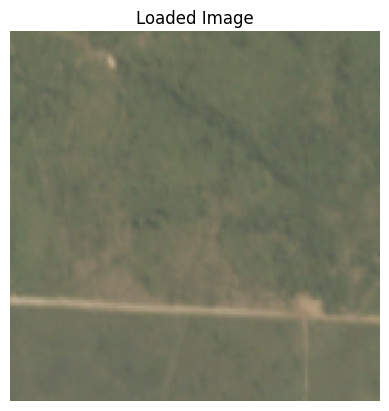

In [33]:
# Predict the class probabilities
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

img_path = './train-jpg/train_10082.jpg' 
img = image.load_img(img_path, target_size=(128, 128)) 
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  
img_array /= 255.0  # Normalize to the range [0, 1]

predictions = model.predict(img_array)
predicted_classes = (predictions > 0.5).astype(int)[0] 
print(predicted_classes)
class_names = [labels[i] for i in range(len(predicted_classes)) if  predicted_classes[i] > 0]
print("Predicted Classes:", class_names)


plt.imshow(img)
plt.axis('off')  # Hide axis
plt.title('Loaded Image')
plt.show()